In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%autoreload 2

import warnings
#warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
print("pandas: ", pd.__version__)
print("seaborn: ",sns.__version__)

pandas:  2.2.2
seaborn:  0.13.2


# Ler microdados do ENEM

## Selecionar apenas uma amostra aleatória de 1% dos alunos
Se a gente lê o arquivo de 3GB inteiro, vai dar problema. Aqui tem uma receita para ler somente x%: https://www.kaggle.com/questions-and-answers/53925 

In [3]:
def skip(i,fraction=0.01):
    if i == 0:
        return False  # precisamos manter o row=0 para ter o header
    else:
        return random.random() > fraction

[skip(i) for i in range(10)]

[False, True, True, True, True, True, True, True, True, True]

A título de exemplo, vamos carregar os dados de 2010.

In [4]:
%time df = pd.read_csv('../inep/enem/2010/DADOS/MICRODADOS_ENEM_2010.csv',skiprows = skip, encoding='latin1',sep=";")

CPU times: user 21.2 s, sys: 1.13 s, total: 22.4 s
Wall time: 37.9 s


In [5]:
df

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ENSINO,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,...,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Q55,Q56,Q57
0,200000000109,2010,7,F,0,2,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200000000266,2010,2,F,0,1,2,1.0,3157807.0,SANTA LUZIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200000000472,2010,2,M,0,2,2,1.0,2311405.0,QUIXERAMOBIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200000000555,2010,2,F,0,3,2,1.0,2304400.0,FORTALEZA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200000000885,2010,7,M,0,1,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46286,200004611317,2010,3,F,0,3,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46287,200004611330,2010,4,M,0,3,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46288,200004611339,2010,3,F,0,2,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46289,200004611373,2010,11,F,1,1,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


De fato, só vem 50 mil linhas (os dados originais devem conter da ordem de 3-6 milhões de participantes)

Em seguinda, vamos filtrar estes dados pela presença na prova, se é treineiro e estar concluindo o EM.

In [7]:
df["TP_PRESENCA_CN"].value_counts(dropna=False)

TP_PRESENCA_CN
1    33977
0    12250
2       64
Name: count, dtype: int64

In [8]:
df['TP_ST_CONCLUSAO'].value_counts(dropna=False)

TP_ST_CONCLUSAO
1    27185
2    13704
3     5402
Name: count, dtype: int64

In [9]:
df["TP_ESTADO_CIVIL"].value_counts(dropna=False)

TP_ESTADO_CIVIL
0    37646
1     7620
2      883
3      142
Name: count, dtype: int64

## Filtrar os dados por presença, treineiro, EM e notas não-zero

In [5]:
def filterdf(df):
    df = df[df["TP_PRESENCA_CN"] == 1]  # presente nas 4 provas
    df = df[df["TP_PRESENCA_CH"] == 1]
    df = df[df["TP_PRESENCA_LC"] == 1]
    df = df[df["TP_PRESENCA_MT"] == 1]
    if "IN_TREINEIRO" in df.columns:
        df = df[(df["IN_TREINEIRO"] == 0) | (df["IN_TREINEIRO"].isna())]  # não é treineiro ou não existe 
    df = df[df["TP_ST_CONCLUSAO"].isin([1, 2])]  # afirma que concluiu EM ou que vai concluir EM no ano da aplicação
    # não queremos as notas == 0
    df = df.query("NU_NOTA_CH != 0 and NU_NOTA_CN != 0 and NU_NOTA_LC != 0 and NU_NOTA_MT != 0")
    df.dropna(subset = ['TX_RESPOSTAS_CN','TX_RESPOSTAS_CH','TX_RESPOSTAS_LC','TX_RESPOSTAS_MT']) # achamos linhas com NaN para estas colunas!
    return df


def load_data(ano,frac,orig=False):
    'carrega dados com determinado ano e fração'
    print(f"processando {ano} com fraçao = {frac*100:.0f}%",ano, frac)
    def skip(i,fraction=frac):
        if i == 0:
            return False  # precisamos manter o row=0 para ter o header
        else:
            return random.random() > fraction
   
    if ano == 2016:
        caminho = f'../inep/enem/{ano}/DADOS/microdados_enem_{ano}.csv'
    else:
        caminho = f'../inep/enem/{ano}/DADOS/MICRODADOS_ENEM_{ano}.csv'
    if orig:
        caminho = f'../inep/enem/orig/{ano}/DADOS/MICRODADOS_ENEM_{ano}.csv'
        if ano == 2016:
            caminho = f'../inep/enem/orig/{ano}/DADOS/microdados_enem_{ano}.csv'
            
    print(caminho)
    df = pd.read_csv(caminho,skiprows = skip, encoding='latin1',sep=";")
    return df
    
def filter_data(df):
    print("filter data...")
    return filterdf(df)

def nome_do_arquivo(ano,frac):
    frac = frac*100
    fn = f'data/enem_{frac:.0f}_{ano}.csv'
    return fn

df = load_data(2023,0.01)
print(len(df))
df = filter_data(df)
print(len(df))

processando 2023 com fraçao = 1% 2023 0.01
../inep/enem/2023/DADOS/MICRODADOS_ENEM_2023.csv
38997
filter data...
21191


In [13]:
#df.to_csv('data/enem_100_2019.csv')

In [6]:
df['TX_RESPOSTAS_CH'][:10]

0     DBAADEADBDCCBDBCEDEBBCADAEDABCACECDAECBAAABCA
1     DBAADECAADECBECCADEBACBDDECACBACDCDCECBDAABCD
2     EBCDBADEDEADEAEDBEDADBECADBDCBDACDECBACCDCBDE
3     ABCDCBDDCDAEACEEDABDDDEADDBEBCEBCEEADCBCDAAAE
4     ABCDDACBCEAABADDBABBEABDADCACDEADBCBCDEEAADAE
5     CDBEAADEBAAEAADECBBAABCDBDBADCDEADDADCDCEBADA
8     BCEBCADEDCDAADEEBCEAEBACCBCBDADEBACCBDBDACEBE
9     DAAADEADCDCABBBCDDEBDBEAABCADCACECEAEBBDAABCD
10    CDAEECABBACDDADECBDAABCDCEBAACDEABCDDCCBCBCDA
12    AEDEECAEDCDAEDEEAADDBCCCABCDCAAEAEBABBADDDDDD
Name: TX_RESPOSTAS_CH, dtype: object

In [7]:
df.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
       'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',

In [8]:
df['TP_ANO_CONCLUIU'].describe()

count    21191.000000
mean         2.400217
std          4.316265
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         17.000000
Name: TP_ANO_CONCLUIU, dtype: float64

## Aqui faremos o trabalho de verdade
Isso deve levar alguns minutos.

In [9]:
frac = 0.01
for ano in range(2023,2024):
    df = load_data(ano,frac)
    df = filter_data(df)
    fn = nome_do_arquivo(ano,frac)
    #print(fn+"...\n")
    df.to_csv(fn,index=False)

import inspect
filter_conditions = inspect.getsource(filterdf)
with open('data/filters.txt','w') as f:
    f.write(filter_conditions)

processando 2023 com fraçao = 1% 2023 0.01
../inep/enem/2023/DADOS/MICRODADOS_ENEM_2023.csv
filter data...


# Preparar os dados para análise TRI
Precisamos converter as respostas e o gabarito no microdados do INEP para um formato que os pacotes de TRI conseguem ler.

## Funções para extrair acertos
A maioria das análises TRI vão precisar de uma "dicomitização" das respostas. A estrutura de dados que vamos precisar é uma matriz com colunas itens e linhas pessoas com valores 0 e 1 para erros e acertos respectivamente.

Vamos tentar criar umas funções que crie este estrutura de dados.


Temos algumas informações sobre a estrutura dos microdados:
* não vamos usar as primeiras 5 itens da prova LC (Linguágens e Códigos). Desde 2011 (?) estas posições são usadas para as questões de língua estrangeira (espanhol ou inglês). Acredito que somente 40 questões de LC são usados para criar a escala IRT desta prova.
* O INEP divulga, desde o final de 2022, os parámetros IRT (discriminação, dificuldade e c). Além disso, dizem quais itens foram eliminados ("pelo IRT"), porque aparentemente atrapalharam a convergência da estimação do modelo IRT 3PL que estão usando. Vamos identificar estes itens, para poder decidir na hora da análise se incluir ou não.  

In [11]:
# Assumimos aqui que as planilhas com informações sobre os itens do INEP já foram convertidos para utf-8 e ficam no diretório DADOS
# TODO: escrevi, posteriormente, uma função load_sample em util.py. Re-escrever esta função (e usar um número fixo N nos arquivos com acertos)
def load_amostra(ano,perc):
    df = pd.read_csv(f'data/enem_{perc}_{ano}.csv',dtype={'CO_PROVA_LC':int,'CO_PROVA_CN':int,'CO_PROVA_CH':int,'CO_PROVA_MT':int})
    item_info = pd.read_csv(f'../inep/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;',engine='python')
    item_info.dropna(subset='CO_ITEM',inplace=True)
    item_info['CO_ITEM'] = item_info['CO_ITEM'].astype(int)
                     
    #print(list(item_info.columns),'\n')
    #print(list(df.columns))
    return df, item_info

df, item_info = load_amostra(2023,1)

In [12]:
def to_acertos(s):
    'resp e gab são strings, retorna uma lista'
    resp = s.iloc[0]
    gab = s.iloc[1]
    return [r == g for r,g in zip(resp,gab)]

def acertos_df(df,exame,as_int=True):
    'Retorna dataframe com acertos. Colunas 1-45 = itens, Linhas = idx do df'
    resp_col = 'TX_RESPOSTAS_' + exame
    gab_col = 'TX_GABARITO_' + exame
    adf = df[[resp_col,gab_col]].apply(to_acertos,axis=1,result_type = "expand")
    adf['acertos'] = adf.sum(axis=1)
    adf['caderno'] = df.loc[:,"CO_PROVA_" + exame]
    if as_int:
        adf = adf.astype("int")
    adf['nota_inep'] = df.loc[:,"NU_NOTA_" + exame]
    adf['candidato'] = df['NU_INSCRICAO']
    adf = adf.set_index('candidato')
    return adf

#item_info = pd.read_csv('data/ITENS_PROVA_2019-utf8.csv')

def reorder_rename_cols(ac,item_info):
    'takes a df with acertos, cuts it up and renames the columns for each caderno and stitches it back again.'
    gb = ac.groupby("caderno")
    
    itemgroups = item_info.groupby("CO_PROVA")
    cadernos = ac['caderno'].value_counts().index[:4] #only the 4 most used cadernos
    groups = []
    for caderno in cadernos:
        #print(caderno)
        itemnames = itemgroups.get_group(caderno).sort_values("CO_POSICAO")["CO_ITEM"].values
        colmap = {i:j for i,j in zip(range(len(itemnames)),itemnames)}
        group = gb.get_group(caderno).rename(colmap,axis=1)
        groups.append(group)
    ac = pd.concat(groups)
    #abondaned_items = item_info.query("IN_ITEM_ABAN == 1")["CO_ITEM"].unique()
    #ac = ac.drop(removed_items,axis=1,errors='ignore')
    abandoned_map = {item:f'{item}-aban' for item in itens.query("IN_ITEM_ABAN == 1").CO_ITEM.unique()}
    ac = ac.rename(columns=abandoned_map)
    return ac

df,itens = load_amostra(2023,1)
ac = acertos_df(df,'MT')
ac = reorder_rename_cols(ac,itens)

In [13]:
ac

,126039,85504,14887-aban,28932,125935,126028,13725,141513,86360-aban,27119,...,27330,16795,141566,125884,84857,125888,125933,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210059388101,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,18,1213,643.6
210059540824,0,0,0,0,1,1,0,1,0,1,...,1,0,0,0,0,1,0,12,1213,472.4
210059615722,0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,10,1213,409.4
210059924367,1,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,15,1213,592.9
210059362809,1,0,1,0,1,0,0,1,0,1,...,1,1,1,0,0,0,0,25,1213,685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210058166096,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,10,1214,508.6
210061815204,1,0,0,0,0,0,1,1,0,0,...,0,1,0,1,1,0,1,12,1214,526.4
210059227633,0,0,0,1,1,0,0,1,1,0,...,0,0,1,0,1,0,1,10,1214,392.3


In [14]:
perc = 1
for ano in range(2022,2024):
    df,itens = load_amostra(ano,perc)
    for area in ['CH', 'CN', 'MT']: # LC tem o problema de 50 itens no gabarito
        ac = acertos_df(df,area)
        ac = reorder_rename_cols(ac,itens)
        ac.to_csv(f'data/ac_{perc}_{ano}_{area}.csv',index=True)



# Informação dos itens

Abaixo carregamos todas as planilhas com informações sobre os itens do ENEM disponibilizadas pelo INEP. Assumimos que as planilhas já foram convertidas para utf8. Em 2009 houve alguns itens sem CO_ITEM. Parece interessante de carregar estes dados sempre usando `dtype={'CO_ITEM':str}`, para que o pandas não interpreta o número como `float`. Vamos guardar estes informações sobre os itens fornecidos pelo INEP em `data/itens_inep.csv`

Além disso, vamos rodar, para todos os itens, funções de Teoria Clássica de Testes (TCT) para ter as informações da taxa de acertos e o coeficiente biserial para todos os itens.

## Planilha com todos os dados do INEP
Por incrível que pareça, a cor AMARELO/A não é padronizado entre anos, nem a capitalização.



In [7]:
def padronizar_amarelo(s):
    if s == 'AMARELO':
        return 'AMARELA'
    else:
        return s

df = pd.DataFrame()
for ano in range(2009,2024):
    item_info = pd.read_csv(f'../dados/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;',
                        engine='python',dtype={'CO_ITEM':str})
    item_info['ano'] = ano
    item_info['TX_COR'] = item_info['TX_COR'].str.upper().str.strip()
    item_info['TX_COR'] = item_info['TX_COR'].apply(padronizar_amarelo)
    df = pd.concat([df,item_info])
    
df.to_csv('data/itens_inep.csv',index=False)

## Calcular estatísticas TCT dos itens
Usamos a função `mirt::itemstats`. A função item_stats em util.py usa o arquivo itens_inep.csv gerado na célula acima e depende também dos arquivos dos acertos gerados acima.

Também inserimos um URL para as resoluções comentados do Objetivo. Cuidado: não checei exaustivamente todos as gambiaras para chegar no URL certo. No notebook Análise de Itens exemplos de como usar as planilhas geradas pela célula abaixo.

In [8]:
from util import item_stats
for ano in range(2023,2024):
    for area in ['MT','CH','CN']: #TODO: resolver problema do LC
        istats = item_stats(ano,area)
        istats.to_csv(f'data/istats-{ano}-{area}.csv',index_label='item')

## Calcular notas e parâmetros da escala ENEM
Podemos transformar as padrões de resposta para uma nota de duas formas: usando a função `mirt::fscore` e nossa própria função . Para transformar as notas que estão distribuídas aproximademente $N(0,1)$ para a "Escala ENEM" (que é aproximadamente $N(500,100)$), precisamos dos parâmetros de conversão, que vamos calcular agora. 

In [18]:
from util import provas,load_padr,score_inep
import scipy

Ano 2009 e prova = 50
Ano 2009 e prova = 51
Ano 2009 e prova = 49
Ano 2009 e prova = 52
Ano 2010 e prova = 92
Ano 2010 e prova = 90
Ano 2010 e prova = 89
Ano 2010 e prova = 91
Ano 2011 e prova = 121
skipping prova 121, to be investigated
Ano 2011 e prova = 124
skipping prova 124, to be investigated
Ano 2011 e prova = 122
skipping prova 122, to be investigated
Ano 2011 e prova = 123
skipping prova 123, to be investigated
Ano 2012 e prova = 143
Ano 2012 e prova = 144
Ano 2012 e prova = 141
Ano 2012 e prova = 142
Ano 2013 e prova = 174
Ano 2013 e prova = 171
Ano 2013 e prova = 172
Ano 2013 e prova = 173
Ano 2014 e prova = 199
Ano 2014 e prova = 201
Ano 2014 e prova = 200
Ano 2014 e prova = 202
Ano 2015 e prova = 235
Ano 2015 e prova = 236
Ano 2015 e prova = 237
Ano 2015 e prova = 238
Ano 2016 e prova = 291
Ano 2016 e prova = 292
Ano 2016 e prova = 293
Ano 2016 e prova = 294
Ano 2017 e prova = 392
Standard error of the regression > 0.01 for ano 2017, area CN and prova 392
slope = 125.51177

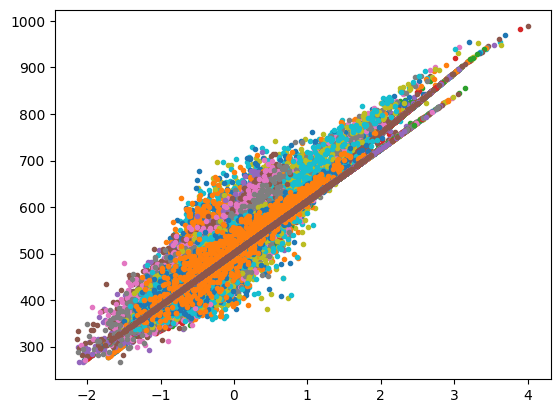

In [44]:
# vamos ter que pular o ano 2011 para a área CN, porque existe um item que não foi marcado como abandonado, 
# mas para qual o INEP não deu os parâmetros IRT
# TODO: investigar se o item foi abandonado (conseguimos reproduzir as notas do INEP sem este item) 
# OU se o item foi usado, mas não sabemos os parâmetros. 
# Estamos com dificuldades de reproduzir exatamente as notas de 2017 e 2018 também. 
# TODO: investigar as razões das discrepâncias para os anos que não conseguimos reproduzir
# TODO: fazer a calibragem para a área LC
results = pd.DataFrame(columns=['ano','area','prova','slope','intercept','stderr'])
for area in ['CN','MT','CH']:
    for ano in range(2009,2024):
        provs = provas(ano,area)
        for prova in provs:
            print(f"Ano {ano} e prova = {prova}")
            padr,notas_inep= load_padr(prova,1000,nota_inep=True)
            if prova in [122,121,123,124]:
                print(f"skipping prova {prova}, to be investigated")
                continue
            notas = score_inep(padr,prova)
            
            x = notas['nota']
            y = notas_inep['nota_inep']
            plt.plot(x,y,'.')
            res = scipy.stats.linregress(x, y)
            if res.stderr > 0.01:
                print(f"Standard error of the regression > 0.01 for ano {ano}, area {area} and prova {prova}")
                print(f"slope = {res.slope}, intercept = {res.intercept}, stderr = {res.stderr}")
            results.loc[len(results)] = [ano,area,prova,res.slope,res.intercept,res.stderr]
    
results['prova'] = results['prova'].astype('int')
results['ano'] = results['ano'].astype('int')    
results.to_csv(f'data/scorecal.csv',index=False)

Uma vez calibrado, podemos agora converter notas e parâmetros dos itens para a escala ENEM

In [56]:
from util import scalecalparams, params_inep, notas_to_enem_scale, irt_params_to_enem_scale

In [76]:
scalecalparams(area='CN')

(np.float64(113.09084261318816), np.float64(501.1487792521128))

In [83]:
params= params_inep(1056)

44

In [87]:
len(irt_params_to_enem_scale(params,1056))

44

In [68]:
padr,nota = load_padr(prova=1058,nota_inep=True)
display(padr,nota)

,44230,67980,75825,82962,83806,87207,88045,95739,95823,96291,...,140721,140914,141030,141048,141072,141148,141322,141355,141364,141384
candidato,,,,,,,,,,,,,,,,,,,,,
210057560956,1,1,0,0,1,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


,acertos,caderno,nota_inep
candidato,,,
210057560956,21,1058,543.9


In [43]:
score_inep(padr,prova=1058,enemscale=True)

,nota,se
candidato,,
210055658956,624.717161,20.53971
